# Explainer Notebook

### PART 1: Gather Data
- Get all links in initial page
- Make dataframe with columns: [URL, Title, List references, List paragraph texts]

### PART 2:
-

In [1]:
# Options
OPTION_PERFORM_SCRAPE = False
OPTION_SAVE_FIG = False
OPTION_SHOW_PLOT = True

In [2]:
# Imports
import requests
from bs4 import BeautifulSoup
import pandas as pd
from util import wiki_util, nlp_util
from tqdm import tqdm
from ast import literal_eval
from collections import defaultdict
import networkx as nx
from netwulf.interactive import visualize
import matplotlib.pyplot as plt
import numpy as np
import community


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/philiphelsted/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/philiphelsted/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/philiphelsted/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [3]:
# Static Variables
LINK_WIKI_ENGLISH = "https://en.wikipedia.org/wiki/Cold_War"
LINK_WIKI_GERMAN = "https://de.wikipedia.org/wiki/Kalter_Krieg"
EVENT_FILTER = ["conflicts", "conflict", "events", "event", "wars", "war", "coups", "coup",
                "crises", "crisis", "coup d'état", "history", "warfare", "battle", "battles"
                "invasion", "invasions", "revolution", "revolutions"]
PERSON_FILTER = ["births", "deaths", "people", "leader", "leaders", "politicians", "politician",
                 "writer", "writers", "scientist", "scientists", "personnel", "family", "families",
                 "executive", "executives", "spy", "spies", "person"]

In [4]:
def get_content_soup(link_wikipedia):
    website = requests.get(link_wikipedia)
    content_soup = BeautifulSoup(website.content)
    return content_soup

def soup_get_title(wiki_content_soup):
    head = wiki_content_soup.find("h1", {"id": "firstHeading"})
    return head.text

def soup_get_reference_links(wiki_content_soup, language="en"):
    p_elements = wiki_content_soup.find_all("p")
    links = [a['href'] for p in p_elements for a in p.find_all("a", href=True)]
    links = [wiki_util.hyperlink_cleanup(link, language) for link in links]
    links = [link for link in links if link != False]
    return links

def soup_get_category_texts(wiki_content_soup, language="en"):
    html_div = wiki_content_soup.find("div", {"id": "mw-normal-catlinks"})
    links_without_categories = html_div.find("ul")
    links = links_without_categories.find_all("a")
    link_texts = [a.text for a in links]
    return link_texts

def soup_get_paragraph_texts(wiki_content_soup):
    p_elements = wiki_content_soup.find_all("p")
    paragraph_texts = [p.text for p in p_elements]
    return paragraph_texts

def get_all_reference_links(link_wikipedia, language):
    website = requests.get(link_wikipedia)
    content_soup = BeautifulSoup(website.content)
    p_elements = content_soup.find_all("p")
    links = [a['href'] for p in p_elements for a in p.find_all("a", href=True)]
    links = [wiki_util.hyperlink_cleanup(link, language) for link in links]
    links = [link for link in links if link != False]
    return links


In [5]:
# Scrape English version
if OPTION_PERFORM_SCRAPE:
    links_to_scan = get_all_reference_links(LINK_WIKI_ENGLISH, "en") + [LINK_WIKI_ENGLISH]
    links_to_scan = sorted(list(set(links_to_scan)))
    data = []
    for url in tqdm(links_to_scan):
        soup = get_content_soup(url)
        title = soup_get_title(soup)
        list_references = soup_get_reference_links(soup, language="en")
        list_paragraph_texts = soup_get_paragraph_texts(soup)
        list_category_texts = soup_get_category_texts(soup)
        data.append([url, title, list_references, list_paragraph_texts, list_category_texts])


In [6]:
# Save English version
if OPTION_PERFORM_SCRAPE:
    COLUMN_NAMES = ['URL', 'TITLE', 'LIST_REFERENCES', 'LIST_PARAGRAPH_TEXTS', "CATEGORIES"]
    df_wikipedia_english = pd.DataFrame(data, columns=COLUMN_NAMES)
    df_wikipedia_english = df_wikipedia_english.set_index('URL')
    df_wikipedia_english.to_csv('./data/wiki_english.csv')

In [7]:
# Scrape German Version
if OPTION_PERFORM_SCRAPE:
    links_to_scan = get_all_reference_links(LINK_WIKI_GERMAN, language="de") + [LINK_WIKI_GERMAN]
    links_to_scan = sorted(list(set(links_to_scan)))
    data = []
    for url in tqdm(links_to_scan):
        soup = get_content_soup(url)
        title = soup_get_title(soup)
        list_references = soup_get_reference_links(soup, language="de")
        list_paragraph_texts = soup_get_paragraph_texts(soup)
        list_category_texts = soup_get_category_texts(soup)
        data.append([url, title, list_references, list_paragraph_texts, list_category_texts])


In [8]:
# Save German Version
if OPTION_PERFORM_SCRAPE:
    COLUMN_NAMES = ['URL', 'TITLE', 'LIST_REFERENCES', 'LIST_PARAGRAPH_TEXTS', "CATEGORIES"]
    df_wikipedia_german = pd.DataFrame(data, columns=COLUMN_NAMES)
    df_wikipedia_german = df_wikipedia_german.set_index('URL')
    df_wikipedia_german.to_csv('./data/wiki_german.csv')

### Load data

In [9]:
#df_wikipedia_english = pd.read_csv('./data/wiki_english.csv', index_col='URL', converters={'LIST_REFERENCES': literal_eval, 'LIST_PARAGRAPH_TEXTS': literal_eval, "CATEGORIES": literal_eval})

#df_wikipedia_english['TYPE'] = df_wikipedia_english_fromCSV.apply(lambda x: wiki_util.get_category(x['CATEGORIES'], EVENT_FILTER, PERSON_FILTER), axis=1)

df_wikipedia_english = pd.read_csv('./data/wiki_english_with_tokens.csv', index_col='URL', converters={'LIST_REFERENCES': literal_eval, 'LIST_PARAGRAPH_TEXTS': literal_eval, "CATEGORIES": literal_eval, "TOKENS": literal_eval, "UNIQUE_TOKENS": literal_eval})

#df_wikipedia_german_fromCSV = pd.read_csv('./data/wiki_german.csv', index_col='URL', converters={'LIST_REFERENCES': literal_eval, 'LIST_PARAGRAPH_TEXTS': literal_eval, "CATEGORIES": literal_eval})


#df_wikipedia_german_fromCSV['TYPE'] = df_wikipedia_german_fromCSV.apply(lambda x: wiki_util.get_category(x['CATEGORIES'], EVENT_FILTER, PERSON_FILTER), axis=1)

# Virker til en vis grænse, nogle småting der ikke bliver fanget ordenligt. None filteret virker bedst.

In [25]:
def get_graph_stats(graph):
    def format_print(str1, str2):
        print("{:>15}".format(str1), "{:>15}".format(str2))

    if graph.is_directed():
        in_degrees = [x[1] for x in graph.in_degree]
        out_degrees = [x[1] for x in graph.out_degree]
    else:
        degrees = [x[1] for x in graph.degree]

    format_print('Statistic', 'Value')
    format_print('N Nodes', len(graph.nodes))
    format_print('N Edges', len(graph.edges))
    if graph.is_directed():
        format_print('Max in_degree', max(in_degrees))
        format_print('Min in_degree', min(in_degrees))
        format_print('Max out_degree', max(out_degrees))
        format_print('Min out_degree', min(out_degrees))
        format_print('Mean in_degree', "{: 2.2f}".format(np.mean(in_degrees)))
        format_print('Mean out_degree', "{: 2.2f}".format(np.mean(out_degrees)))
    else:
        format_print('Max degree', max(degrees))
        format_print('Min degree', min(degrees))
        format_print('Mean degree', "{: 2.2f}".format(np.mean(degrees)))

def produce_communities(graph, resolution=0.3):
    list_communities = nx.community.louvain_communities(graph, seed=1, resolution=resolution)
    #list_communities = community.best_partition(subgraph)

    print(len(list_communities))

    nice_colors = ['#0fdbff', '#0fdbff', '#ff0fb3', '#5e3582', '#ffe70f', '#1e9648', '#1e6296', '#4a1e96', '#961e6a', '#51888c']

    DEFAULT_COLOR = '#8c8c8c'
    partition_colors = defaultdict(lambda: DEFAULT_COLOR)

    for i in range(len(nice_colors)):
        partition_colors[i] = nice_colors[i]

    for node in graph.nodes:
        for i in range(len(list_communities)):
            if node in list_communities[i]:
                graph.nodes[node]['color'] = partition_colors[i]
                graph.nodes[node]['community'] = i

    return graph, len(list_communities)


In [11]:
en_edge_list = wiki_util.get_edge_list(df_wikipedia_english)
en_edge_list_directed = wiki_util.get_edge_list(df_wikipedia_english, directed=True)

graph_en = nx.Graph()
graph_en.add_weighted_edges_from(en_edge_list)
graph_en = wiki_util.generate_graph_with_node_attributes(graph_en, df_wikipedia_english)

graph_en_directed = nx.DiGraph()
graph_en_directed.add_weighted_edges_from(en_edge_list_directed)
graph_en_directed = wiki_util.generate_graph_with_node_attributes(graph_en_directed, df_wikipedia_english)

100%|██████████| 859/859 [00:00<00:00, 2594.69it/s]


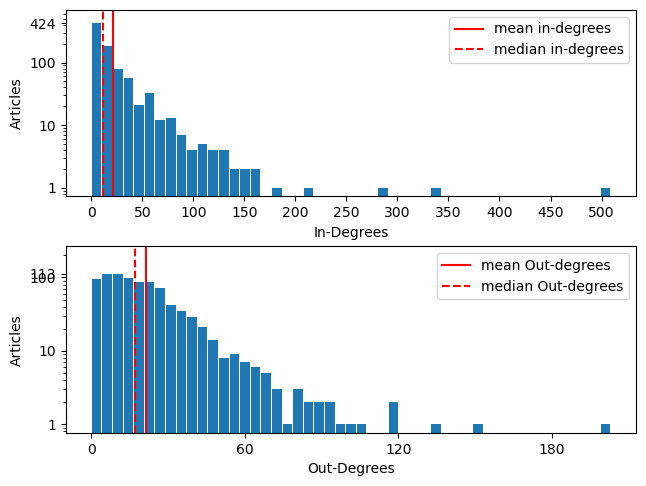

In [12]:

G = graph_en_directed


if OPTION_SHOW_PLOT:
    in_degrees = [x[1] for x in G.in_degree]
    out_degrees = [x[1] for x in G.out_degree]
    bins = np.linspace(min(in_degrees), max(in_degrees), 50)

    mean = np.mean(in_degrees)
    median = np.median(in_degrees)

    hist, edges = np.histogram(in_degrees, bins=bins)
    x = (edges[1:] + edges[:-1])/2
    width = bins[1] - bins[0]
    fig, axs = plt.subplots(2)
    axs[0].bar(x, hist, width=width*0.9)

    axs[0].set_xlabel('In-Degrees')
    axs[0].set_ylabel('Articles')
    axs[0].set_yscale('log')
    axs[0].set_xticks(range(0, 501, 50))
    axs[0].set_yticks([10**0, 10**1, 10**2, max(hist)], labels=[10**0, 10**1, 10**2, max(hist)])
    axs[0].axline((mean, 0), (mean, max(in_degrees)), color='red', label='mean in-degrees')
    axs[0].axline((median, 0), (median, max(in_degrees)), linestyle='--', color='red', label='median in-degrees')
    axs[0].legend()

    bins = np.linspace(min(out_degrees), max(out_degrees), 50)

    mean = np.mean(out_degrees)
    median = np.median(out_degrees)

    hist, edges = np.histogram(out_degrees, bins=bins)
    x = (edges[1:] + edges[:-1])/2
    width = bins[1] - bins[0]
    axs[1].bar(x, hist, width=width*0.9)

    axs[1].set_xlabel('Out-Degrees')
    axs[1].set_ylabel('Articles')
    axs[1].set_yscale('log')
    axs[1].set_xticks(range(0, int(max(list(bins))), 60))
    axs[1].set_yticks([10**0, 10**1, 10**2, max(hist)], labels=[10**0, 10**1, 10**2, max(hist)])
    axs[1].axline((mean, 0), (mean, max(out_degrees)), color='red', label='mean Out-degrees')
    axs[1].axline((median, 0), (median, max(out_degrees)), linestyle='--', color='red', label='median Out-degrees')
    axs[1].legend()
    fig.tight_layout(pad=0.5)
    plt.show()
    if OPTION_SAVE_FIG:
        fig.savefig("./images/degree_distributions.png")

# TK IDF

In [13]:
df_wikipedia_english

,TITLE,LIST_REFERENCES,LIST_PARAGRAPH_TEXTS,CATEGORIES,TYPE,TOKENS,UNIQUE_TOKENS
URL,,,,,,,
"https://en.wikipedia.org/wiki/1,000,000,000_(number)","1,000,000,000","[https://en.wikipedia.org/wiki/Billion, https:...","[1,000,000,000 (one billion, short scale; one ...","[Integers, Large numbers]",none,"[one, billion, short, scale, one, thousand, mi...","{bil, evidence, asian, term, whereas, yard, va..."
https://en.wikipedia.org/wiki/17th_parallel_north,17th parallel north,[https://en.wikipedia.org/wiki/Circle_of_latit...,[The 17th parallel north is a circle of latitu...,[Circles of latitude],none,"[th, parallel, north, circle, latitude, degree...","{west, vietnamese, particularly, tuy, line, ri..."
https://en.wikipedia.org/wiki/1947_Polish_legislative_election,1947 Polish legislative election,[https://en.wikipedia.org/wiki/Edward_Os%C3%B3...,"[\n, Edward Osóbka-Morawski\nPPS\n, Józef Cyra...","[Electoral fraud in Poland, 1947 elections in ...",event,"[edward, o, bka, morawski, pps, j, zef, cyrank...","{new, predict, enough, allowed, aron, pretense..."
https://en.wikipedia.org/wiki/1948_Czechoslovak_coup_d%27%C3%A9tat,1948 Czechoslovak coup d'état,[https://en.wikipedia.org/wiki/Communist_Party...,"[\n, In late February 1948, the Communist Part...","[Cold War conflicts, 1948 in Czechoslovakia, P...",event,"[late, february, communist, party, czechoslova...","{endangering, determination, reached, step, of..."
https://en.wikipedia.org/wiki/1948_Italian_general_election,1948 Italian general election,[https://en.wikipedia.org/wiki/Alcide_De_Gaspe...,"[\n, Alcide De Gasperi\nChristian Democracy\n,...","[1948 elections in Europe, 1948 elections in I...",event,"[alcide, de, gasperi, christian, democracy, al...","{determination, new, atom, term, pointed, bent..."
...,...,...,...,...,...,...,...
https://en.wikipedia.org/wiki/Yekaterinburg,Yekaterinburg,[https://en.wikipedia.org/wiki/Help:IPA/Englis...,"[\n, Yekaterinburg (/jɪˈkætərɪnbɜːrɡ/ yih-KAT-...","[Yekaterinburg, Yekaterinburgsky Uyezd, Popula...",event,"[yekaterinburg, j, k, r, nb, r, yih, kat, r, b...","{religion, reached, zoo, veteran, unesco, enou..."
https://en.wikipedia.org/wiki/Yom_Kippur_War,Yom Kippur War,"[https://en.wikipedia.org/wiki/Israel, https:/...","[\n, Egyptian front\n, International front\n, ...","[Yom Kippur War, 1973 in Egypt, Conflicts in 1...",event,"[egyptian, front, international, front, yom, k...","{squad, reason, dog, occupying, reached, conta..."
https://en.wikipedia.org/wiki/Yugoslavia,Yugoslavia,[https://en.wikipedia.org/wiki/Geographic_coor...,"[\n, Coordinates: 44°49′N 20°27′E﻿ / ﻿44.817°N...","[Yugoslavia, Former countries in the Balkans, ...",none,"[coordinate, n, e, n, e, yugoslavia, ju, sl, v...","{reason, religion, occupying, determination, l..."


In [14]:
def get_tokens_for_community(graph, community):
    all_tokens = []
    unique_tokens = []
    for (n, d) in graph.nodes(data=True):
        if d['community'] == community:
            all_tokens += d['TOKENS']
            unique_tokens += (d['UNIQUE_TOKENS'])

    return all_tokens, set(unique_tokens)

In [56]:
graph_en = nx.Graph()
graph_en.add_weighted_edges_from(en_edge_list)
graph_en = wiki_util.generate_graph_with_node_attributes(graph_en, df_wikipedia_english)
graph_en = wiki_util.get_subgraph(graph_en, attribute='TYPE', values=['person'])

graph_en_communities, communities = produce_communities(graph_en, resolution=1)
print(communities)

community_tokens = [get_tokens_for_community(graph_en_communities, c) for c in range(communities)]

14
14


In [57]:

for i in range(communities):
    print("Community", i)
    (all_tokens, unique_tokens) = community_tokens[i]
    print(len(unique_tokens))

Community 0
81
Community 1
6307
Community 2
140
Community 3
10668
Community 4
752
Community 5
331
Community 6
163
Community 7
5819
Community 8
92
Community 9
13759
Community 10
19404
Community 11
2686
Community 12
621
Community 13
16800


In [62]:
(all_tokens, unique_tokens) = community_tokens[0]
nlp_util.get_idf(unique_tokens, all_tokens)

{'oriental': 3.9512437185814275,
 'run': 3.9512437185814275,
 'inaugural': 3.9512437185814275,
 'especially': 3.9512437185814275,
 'new': 3.9512437185814275,
 'shlaim': 3.9512437185814275,
 'part': 3.9512437185814275,
 'gave': 3.9512437185814275,
 'h': 2.4471663218051534,
 'bbc': 3.9512437185814275,
 'war': 3.545778610473263,
 'blair': 3.9512437185814275,
 'expert': 3.9512437185814275,
 'november': 3.9512437185814275,
 'include': 3.9512437185814275,
 'tripp': 2.8526314299133175,
 'middle': 3.0349529867072724,
 'foreign': 3.9512437185814275,
 'politics': 3.0349529867072724,
 'islamic': 3.9512437185814275,
 'advise': 3.9512437185814275,
 'school': 3.9512437185814275,
 'international': 3.9512437185814275,
 'street': 3.9512437185814275,
 'author': 3.9512437185814275,
 'history': 3.9512437185814275,
 'broadcaster': 3.9512437185814275,
 'african': 3.9512437185814275,
 'world': 3.9512437185814275,
 'postgraduate': 3.9512437185814275,
 'team': 3.9512437185814275,
 'academic': 3.951243718581427

In [ ]:
en_subgraph = wiki_util.get_subgraph(graph_en, attribute="Type", values=['person', 'event'])

en_subgraph_directed = wiki_util.get_subgraph(graph_en_directed, attribute="Type", values=['person', 'event'])

en_subgraph_directed_withthreshold = wiki_util.threshold_node_degree_directed(en_subgraph_directed, max=[30,30])

In [ ]:
import importlib
importlib.reload(nlp_util)
print()